In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# constants
G = 9.81  # m/s^2
R_air = 8314.5 / 28.96  # gas constant for air (in J/kg*K)
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    temp=25 + 273.15,  # ambient air temperature (in K)
    pressure=100000,  # ambient air pressure (in Pa)
)
ambient["rho"] = ambient["pressure"] / (
    R_air * ambient["temp"]
)  # ambient air density (in kg/m^3)

cycle = dict(time=range(0, 60), kph=[60, 90, 120], name="constant velocity")


vehicle = dict(
    mass=1500,  # vehicle mass [kg]
    C_drag=0.33,  # drag coefficient [-]
    A_front=2.2,  # frontal area for drag [m^2]
    C_roll_0=0.009,  # tire rolling resistance coefficient [-]
    p_tire=3.0,
    Wdot_access=500,  # average accessory loads [W]
    eta_elec=0.70,  # efficiency of alternator or electrical system for accessories [-]
    eta_a=0.25,  # constant for powertrain efficency   eta_tr = eta_a*
    eta_Wdot1=1e6,  # reference power to account for efficiency variation with load [W]
    eta_Wdot2=1e-6,  # reference power to account for efficiency variation with load [W]
)

In [5]:
# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(t, y, cycle, vehicle, amb, index):
    # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)

    v_veh = np.interp(t, cycle["time"], cycle["v_veh"])
    dv_vehdt = np.interp(t, cycle["time"], cycle["dv_vehdt"])
    alpha = np.pi / 180 * np.interp(t, cycle["time"], cycle["alpha"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    # Determine instantaneous vehicle load (power demand for engine)
    if v_veh > 0:
        C_roll = vehicle["C_roll_0"] + 1 / vehicle["p_tire"] * (
            0.01 + 9.5e-7 * v_veh**2
        )
        Wdot_veh = (
            vehicle["mass"]
            * (max(0, dv_vehdt + G * np.sin(alpha)) + C_roll * G * np.cos(alpha))
            + vehicle["C_drag"]
            * vehicle["A_front"]
            * 0.5
            * amb["rho"]
            * (v_veh - amb["v_air"]) ** 2
        ) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]
    else:
        Wdot_veh = vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    eta = vehicle["eta_a"] * (
        np.exp(-Wdot_veh / vehicle["eta_Wdot1"])
        - np.exp(-Wdot_veh / vehicle["eta_Wdot2"])
    )
    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt

In [6]:
# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0

for idx, speed in enumerate(cycle["kph"]):
    arr_length = len(cycle["time"])

    #  driving cycle vehicle velocities [m/s]
    cycle["v_veh"] = [speed * 1000 / 3600] * arr_length
    # road angle to horizontal  [deg.]
    cycle["alpha"] = [0] * arr_length
    # Calculate vehicle acceleration and identify times when acceleration is positive
    cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

    # Call an ODE integrator to solve for y(t)
    sol = solve_ivp(
        dydt_vehicle,
        [0, 60],
        y_0,
        "RK45",
        args=(cycle, vehicle, ambient, index),
        rtol=1e-4,
        atol=1e-4,
    )

    vehicle["x"] = sol.y[index["x"]] / 1000
    vehicle["E_veh"] = sol.y[index["E_veh"]] / 1000
    vehicle["E_fuel"] = sol.y[index["E_fuel"]] / 1000

    vehicle["kJperkm"] = (
        vehicle["kJperkm"] if "kJperkm" in vehicle else [0] * len(cycle["kph"])
    )
    vehicle["kmperliter"] = (
        vehicle["kmperliter"] if "kmperliter" in vehicle else [0] * len(cycle["kph"])
    )
    vehicle["mpg"] = vehicle["mpg"] if "mpg" in vehicle else [0] * len(cycle["kph"])

    vehicle["kJperkm"][idx] = (
        vehicle["E_fuel"][-1] / vehicle["x"][-1]
    )  # MJ of fuel energy demand per km
    vehicle["kmperliter"][idx] = (
        1000 * vehicle["x"][-1] / (vehicle["E_fuel"][-1] / energydensity_fuel)
    )
    vehicle["mpg"][idx] = 2.35215 * vehicle["kmperliter"][idx]

    #  Allocate memory for vectors for calculating vehicle power requirements
    vehicle["Wdot_drag"] = np.zeros(len(cycle["time"]))
    vehicle["Wdot_roll"] = np.zeros(len(cycle["time"]))
    vehicle["Wdot_accel"] = np.zeros(len(cycle["time"]))

    # Calculate instanaeous power (in kW) to overcome forces on vehicle
    #   and integrate to get total work required (in kWh)
    vehicle["Wdot_drag"] = (
        (
            np.array(
                vehicle["C_drag"]
                * vehicle["A_front"]
                * 0.5
                * ambient["rho"]
                * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
            )
        )
        * cycle["v_veh"]
        / 1000
    )

    C_roll = vehicle["C_roll_0"] + (
        1 / vehicle["p_tire"] * (0.01 + 9.5e-7 * np.array(cycle["v_veh"]) ** 2)
    )
    vehicle["Wdot_roll"] = (
        vehicle["mass"] * C_roll * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
    )
    vehicle["Wdot_accel"] = (
        np.maximum(0, vehicle["mass"] * cycle["dv_vehdt"])  # * cycle["v_veh"] / 1000
    )
    vehicle["Wdot_access_vec"] = (
        np.ones(len(cycle["time"]))
        * vehicle["Wdot_access"]
        / vehicle["eta_elec"]
        / 1000
    )
    vehicle["Wdot"] = (
        vehicle["Wdot_drag"]
        + vehicle["Wdot_roll"]
        + vehicle["Wdot_accel"]
        + vehicle["Wdot_access_vec"]
    )
    #  vehicle["mpg"] = vehicle["mpg"] if "mpg" in vehicle else [0] * len(cycle["kph"])
    # Set up a trapezoidal integration to solve the average values for the cycle
    for key in [
        "Wdot_drag",
        "Wdot_roll",
        "Wdot_accel",
        "Wdot_access_vec",
        "Wdot",
    ]:
        key_avg = f"{key}_avg"
        vehicle[key_avg] = (
            vehicle[key_avg] if key_avg in vehicle else np.ones(len(cycle["kph"]))
        )

        vehicle[key_avg][idx] = (
            np.trapz(vehicle[key], cycle["time"]) / cycle["time"][-1]
        )

(60.0, 120.0)

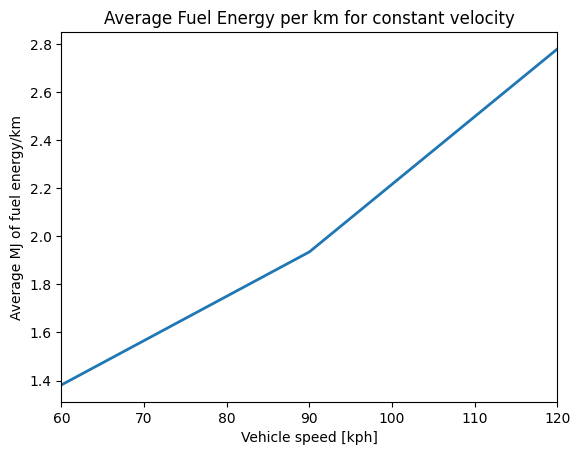

In [7]:
# Plot the average kJ required per km traveled
plt.plot(cycle["kph"], np.array(vehicle["kJperkm"]) / 1000, linewidth=2)
plt.xlabel("Vehicle speed [kph]")
plt.ylabel("Average MJ of fuel energy/km")
plt.title(f'Average Fuel Energy per km for {cycle["name"]}')
plt.xlim(60, 120)

Text(0.5, 1.0, 'Average Vehicle Loads for constant velocity')

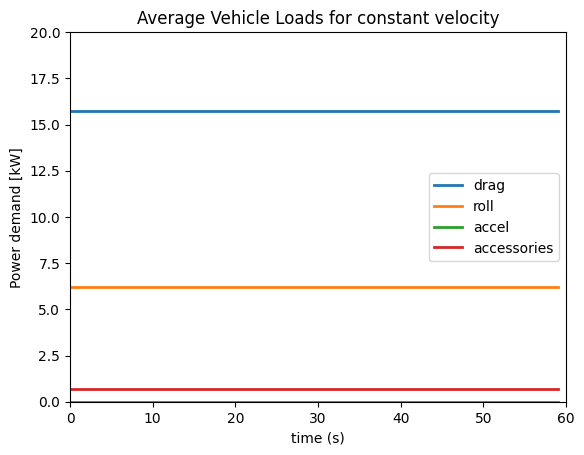

In [8]:
# Plot instantaneous power required for each load for the last cycle
plt.plot(cycle["time"], vehicle["Wdot_drag"], label="drag", linewidth=2)
plt.plot(cycle["time"], vehicle["Wdot_roll"], label="roll", linewidth=2)
plt.plot(cycle["time"], vehicle["Wdot_accel"], label="accel", linewidth=2)
plt.plot(cycle["time"], vehicle["Wdot_access_vec"], label="accessories", linewidth=2)
plt.xlabel("time (s)")
plt.ylabel("Power demand [kW]")
plt.ylim([0, 20])
plt.xlim(0, 60)
plt.legend()
plt.title(f'Average Vehicle Loads for {cycle["name"]}')

KeyError: 'Wdot_access_avg'

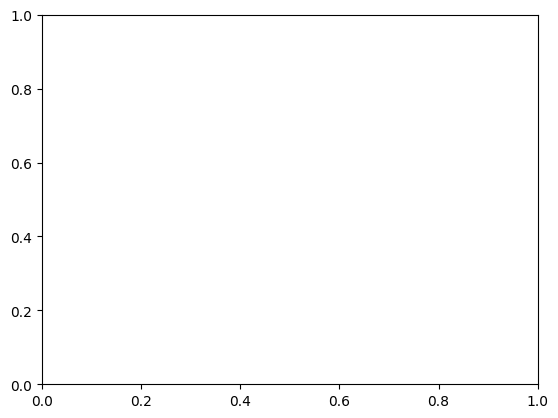

In [9]:
# Plot average power demand for each force or load
categories = ['drag', 'roll', 'accel', 'accessories']
num_categories = len(categories)
num_values = len(vehicle['Wdot_drag_avg'])  # Assuming all lists have the same length

# Setting up the bar width and positions
bar_width = 0.2
# Create an array for the positions of groups
index = np.arange(num_categories)  

fig, ax = plt.subplots()

for i in range(num_values):
    # Creating the bars for each category
    ax.bar(index - bar_width/2 + i * bar_width, 
           [vehicle['Wdot_drag_avg'][i], vehicle['Wdot_roll_avg'][i], 
            vehicle['Wdot_accel_avg'][i], vehicle['Wdot_access_avg'][i]], 
           bar_width, label=f'{i*30 + 60}kph')

# Additional chart settings
ax.set_ylabel('Average Power demand over cycle (kW)')
ax.set_title(f'Average Power Demand for {cycle["name"]}')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

(60.0, 120.0)

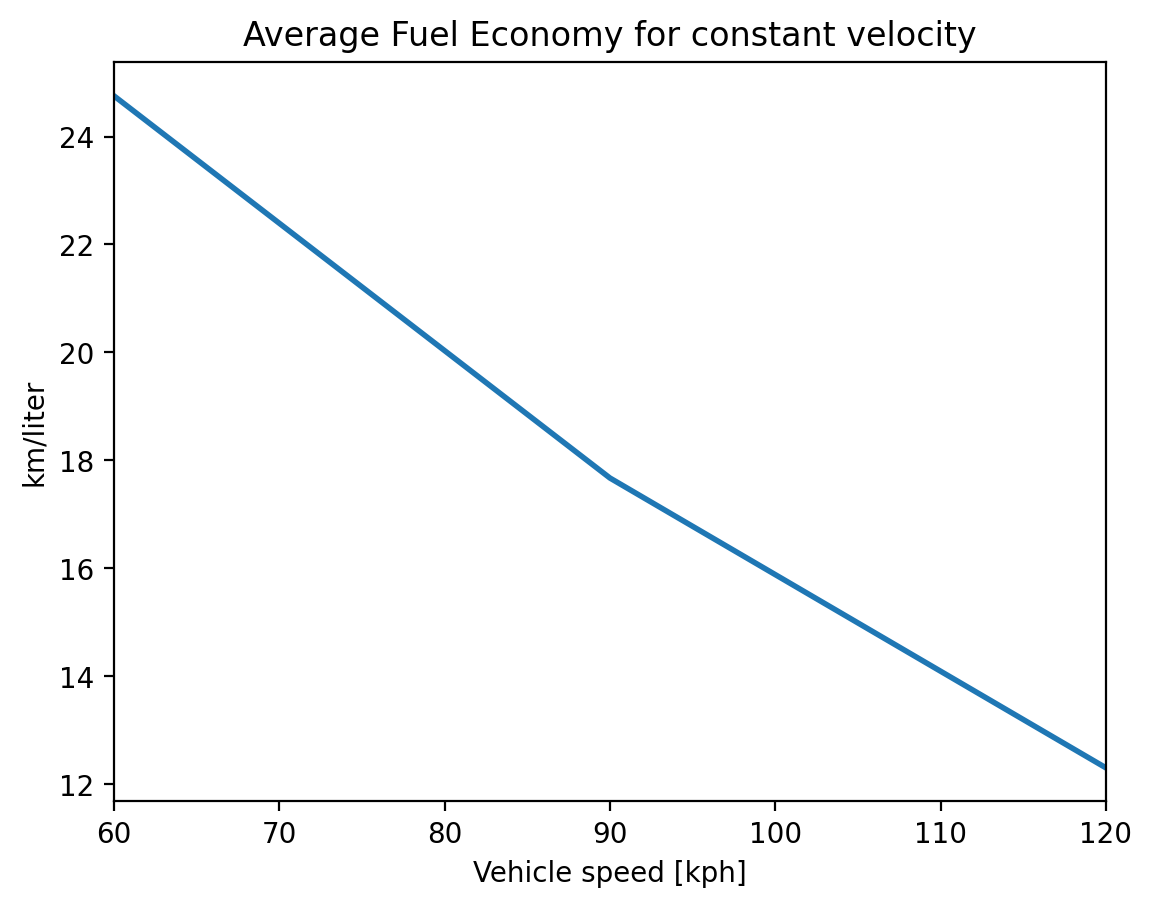

In [ ]:
# Plot averge fuel economy for vehicle
plt.plot(cycle["kph"], vehicle["kmperliter"], linewidth=2)
plt.xlabel("Vehicle speed [kph]")
plt.ylabel("km/liter")
plt.title(f'Average Fuel Economy for {cycle["name"]}')
plt.xlim(60, 120)